In [1]:
# --- PHASE 1: MOUNT GOOGLE DRIVE ---

from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Verify the base path
DRIVE_PATH = '/content/drive/MyDrive'
print(f"Drive mounted. Check files in: {DRIVE_PATH}")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted. Check files in: /content/drive/MyDrive


In [2]:
# --- PHASE 2: UNZIP THE BIBLE DATA (CONFIRMED PATH) ---

import zipfile

ZIP_FILE_PATH = '/content/drive/MyDrive/Bible-kjv-master.zip'
EXTRACT_DIR = '/content/bible_data'

# Create a destination directory in the Colab temporary environment
!mkdir -p "$EXTRACT_DIR"

# Use Python's zipfile module for more reliable unzipping in Colab
print(f"Unzipping {ZIP_FILE_PATH} to {EXTRACT_DIR}...")
try:
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

    # The JSON files are located here:
    FINAL_DATA_DIR = os.path.join(EXTRACT_DIR, 'Bible-kjv-master')

    # Check for the existence of one key file to confirm the path
    test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')

    if os.path.exists(test_file):
        print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
    else:
        # Fallback for a potential immediate unzip (no master folder)
        FINAL_DATA_DIR = EXTRACT_DIR
        test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')
        if os.path.exists(test_file):
             print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
        else:
            print(f"❌ FATAL ERROR: Cannot confirm path to individual JSON files.")

except Exception as e:
    print(f"❌ FATAL ERROR during unzipping: {e}")

Unzipping /content/drive/MyDrive/Bible-kjv-master.zip to /content/bible_data...
✅ Success! Individual book JSON files found in: /content/bible_data/Bible-kjv-master


In [4]:
# --- PHASE 3: ANALYSIS ---


import pandas as pd
import numpy as np
import os
import json

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

# --- 1. Comprehensive Data Calculation ---
def create_comprehensive_analysis_table(data_dir):
    """Calculates all metrics (Word Count, Impact, Focus Score, Intensity) and returns a single table."""
    data = []

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print(f"Error: Directory not found at: {data_dir}")
        return pd.DataFrame()

    print(f"Found {len(json_files)} book files. Calculating all metrics...")

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            book_text = " ".join(full_book_text).lower()
            total_words = len(book_text.split())

            # --- Thematic Metrics ---
            holy_count = book_text.count(" holy ") + book_text.count(" holiness")

            if total_words > 0:
                book_name = book_info.get('book', filename.replace('.json', ''))

                data.append({
                    'Book': book_name,
                    'Total Words': total_words,
                    'Holy Count': holy_count, # Raw count
                    'Holiness Intensity': (holy_count / total_words) * 1000 # Count per 1000 words
                })

        except Exception:
            continue

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ Calculation failed: No valid data processed.")
        return pd.DataFrame()

    # --- 2. Normalization (Impact %) ---
    total_corpus_words = df['Total Words'].sum()
    df['Impact (%)'] = (df['Total Words'] / total_corpus_words) * 100

    # --- 3. Formatting and Renaming ---
    df = df.rename(columns={'Holy Count': 'Holiness Focus Score (Raw Count)'})

    # Round numerical data
    df['Impact (%)'] = df['Impact (%)'].round(2)
    df['Holiness Intensity (Per 1000 Words)'] = df['Holiness Intensity'].round(2)
    df.drop(columns=['Holiness Intensity'], inplace=True)

    # Sort by the most impactful thematic score (Raw Count)
    df_sorted = df.sort_values(by='Holiness Focus Score (Raw Count)', ascending=False).reset_index(drop=True)

    # Add a final summary row
    total_focus = df_sorted['Holiness Focus Score (Raw Count)'].sum()

    df_sorted.loc[len(df_sorted)] = {
        'Book': '**TOTAL CORPUS**',
        'Total Words': total_corpus_words,
        'Holiness Focus Score (Raw Count)': total_focus,
        'Impact (%)': 100.00,
        'Holiness Intensity (Per 1000 Words)': (total_focus / total_corpus_words) * 1000
    }

    # Format percentage and intensity columns for presentation
    df_sorted['Impact (%)'] = df_sorted['Impact (%)'].astype(str) + '%'
    df_sorted['Holiness Intensity (Per 1000 Words)'] = df_sorted['Holiness Intensity (Per 1000 Words)'].astype(str)

    return df_sorted

# --- EXECUTION ---
final_df = create_comprehensive_analysis_table(FINAL_DATA_DIR)

if not final_df.empty:
    print("\n## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus")
    print("The table below synthesizes all word count and 'Holiness' theme metrics.")

    # Print the DataFrame in Markdown format
    print(final_df.to_markdown(index=True, numalign="left", stralign="left"))

Found 67 book files. Calculating all metrics...

## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus
The table below synthesizes all word count and 'Holiness' theme metrics.
|    | Book             | Total Words   | Holiness Focus Score (Raw Count)   | Impact (%)   | Holiness Intensity (Per 1000 Words)   |
|:---|:-----------------|:--------------|:-----------------------------------|:-------------|:--------------------------------------|
| 0  | Leviticus        | 24540         | 69                                 | 3.11%        | 2.81                                  |
| 1  | Isaiah           | 37040         | 56                                 | 4.69%        | 1.51                                  |
| 2  | Acts             | 24245         | 53                                 | 3.07%        | 2.19                                  |
| 3  | Ezekiel          | 39402         | 46                                 | 4.99%        | 1.17                                  |
| 4  

Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting analysis...

--- Top 10 Books by Holiness Intensity (with Word Count) ---
| Book            |   Total Words |   Holy Count |   Holiness Intensity |
|:----------------|--------------:|-------------:|---------------------:|
| 2 Peter         |          1553 |            6 |              3.86349 |
| 1 Thessalonians |          1837 |            7 |              3.81056 |
| Jude            |           608 |            2 |              3.28947 |
| Obadiah         |           669 |            2 |              2.98954 |
| Leviticus       |         24540 |           69 |              2.81174 |
| Ephesians       |          3022 |            7 |              2.31635 |
| Titus           |           896 |            2 |              2.23214 |
| Acts            |         24245 |           53 |              2.18602 |
| Habakkuk        |          1475 |            3 |              2.0339  |
| 1 Pet

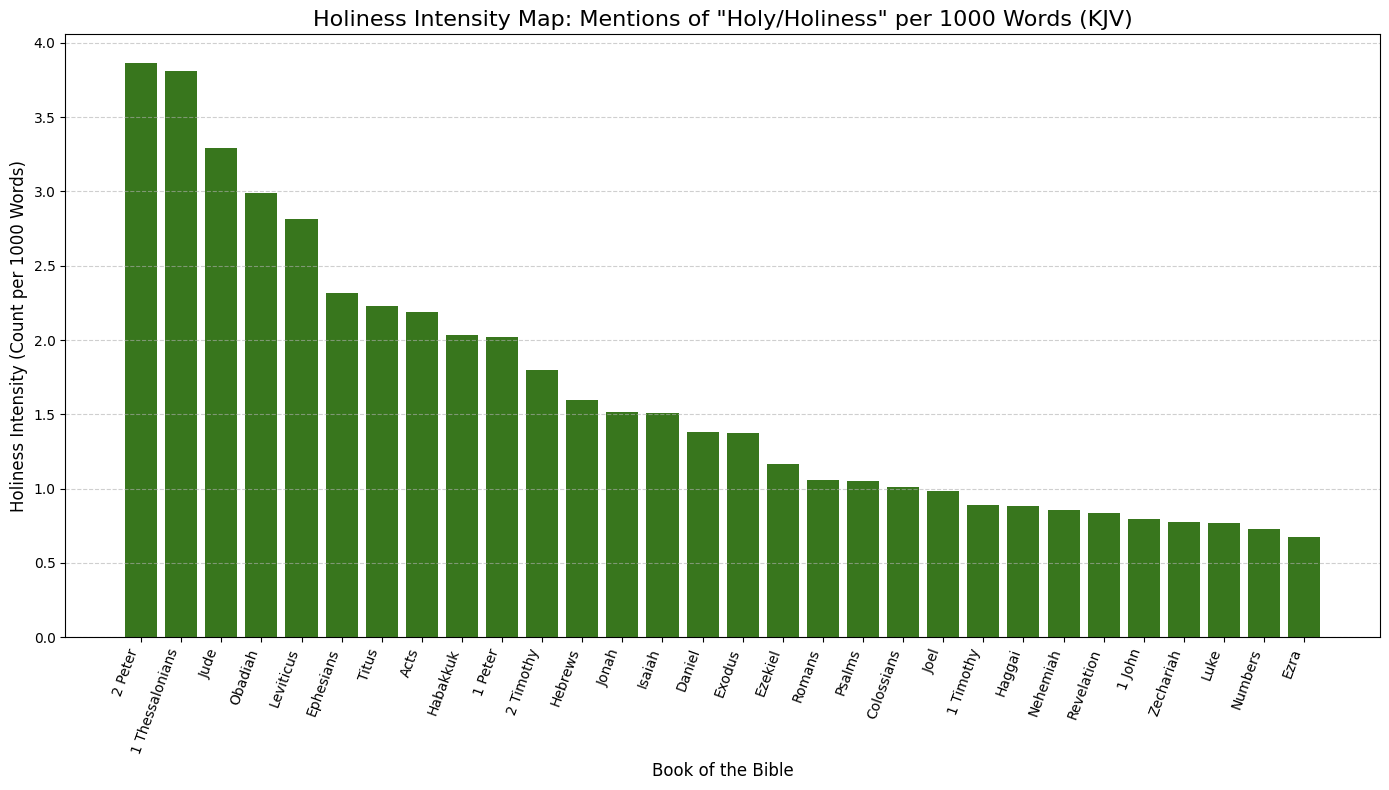

In [5]:
# --- PHASE 4: ANALYSIS AND VISUALIZATION ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
# Removed: from IPython.display import display, Markdown # Removed for environment compatibility

# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def analyze_holiness_intensity_individual_json():
    """Reads all individual JSON files in the directory and calculates Intensity."""

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")

    data = []

    try:
        # Get a list of all JSON files in the directory
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])


    print(f"Found {len(json_files)} book files. Starting analysis...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

        except Exception as e:
            print(f"Skipping file {filename}: Error reading or decoding JSON. {e}")
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict):
            # print(f"Skipping file {filename}: Unexpected primary data format.")
            continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text = []

        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text.append(verse_text)


        book_text = " ".join(full_book_text).lower()

        if not book_text: continue

        # 4. Run the NLP analysis
        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        # --- NEW: Calculate Total Words ---
        total_words = len(book_text.split())
        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        data.append({
            'Book': book_name,
            'Total Words': total_words, # <-- ADDED TO DICTIONARY
            'Holy Count': holy_count,
            'Holiness Intensity': intensity
        })

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ FATAL ERROR: The final DataFrame is EMPTY after processing all files.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False)

    # --- 5. Generate the Visualization ---
    df_top_30 = df_sorted.head(30)

    plt.figure(figsize=(14, 8))
    plt.bar(df_top_30['Book'], df_top_30['Holiness Intensity'], color='#38761d')

    plt.xticks(rotation=70, ha='right')
    plt.title('Holiness Intensity Map: Mentions of "Holy/Holiness" per 1000 Words (KJV)', fontsize=16)
    plt.ylabel('Holiness Intensity (Count per 1000 Words)', fontsize=12)
    plt.xlabel('Book of the Bible', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    graph_filename = 'Holiness_Intensity_Map.png'
    plt.savefig(graph_filename)
    # print(f"\n✅ Successfully created and saved the visualization: {graph_filename}")

    return df_sorted

# --- EXECUTION ---
holiness_df = analyze_holiness_intensity_individual_json()

# 6. Print the final results for the report, including 'Total Words'
if not holiness_df.empty:
    print("\n--- Top 10 Books by Holiness Intensity (with Word Count) ---")

    # MODIFICATION: Included 'Total Words' in the displayed columns
    print(holiness_df[['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']].head(10).to_markdown(index=False))

    # Save the full DataFrame to CSV
    csv_filename = 'holiness_intensity_data.csv'
    holiness_df.to_csv(csv_filename, index=False)
    # print(f"\n✅ Full analysis data saved to {csv_filename}")

else:
    print("\n❌ Final Output Failure: Cannot display results.")

In [7]:
import pandas as pd
import numpy as np
import os
import json
import re

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

# --- 1. Comprehensive Data Calculation with Regex ---
def create_comprehensive_analysis_table_fixed(data_dir):
    """Calculates all metrics using regex for accurate word and theme counts."""
    data = []

    try:
        # Sort files to maintain book order consistency
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print(f"Error: Directory not found at: {data_dir}")
        return pd.DataFrame()

    print(f"Found {len(json_files)} book files. Calculating all metrics with robust counting...")

    # Regex to find any sequence of 3 or more alphabetic characters (robust word count, excluding short articles/prepositions)
    WORD_PATTERN = re.compile(r'\b[a-z]{3,}\b')
    # Regex to find "holy" or "holiness" as whole words (case-insensitive)
    HOLY_PATTERN = re.compile(r'\bholy\b|\bholiness\b')

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            book_text = " ".join(full_book_text).lower()

            # --- FIXED CALCULATION 1: Robust Total Word Count ---
            total_words = len(WORD_PATTERN.findall(book_text))

            # --- FIXED CALCULATION 2: Robust Holiness Focus Score (Raw Count) ---
            holy_count = len(HOLY_PATTERN.findall(book_text))

            if total_words > 0:
                book_name = book_info.get('book', filename.replace('.json', ''))

                data.append({
                    'Book': book_name,
                    'Total Words': total_words,
                    'Holiness Focus Score': holy_count,
                    'Holiness Intensity': (holy_count / total_words) * 1000 # Count per 1000 words
                })

        except Exception:
            continue

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ Calculation failed: No valid data processed.")
        return pd.DataFrame()

    # --- 2. Normalization (Impact %) and Formatting ---
    total_corpus_words = df['Total Words'].sum()
    df['Impact (%)'] = (df['Total Words'] / total_corpus_words) * 100

    # --- 3. Final Table Assembly ---

    # Calculate Total Row values
    total_focus = df['Holiness Focus Score'].sum()
    total_intensity = (total_focus / total_corpus_words) * 1000

    # Create and append the summary row
    summary_row = pd.DataFrame([{
        'Book': '**TOTAL CORPUS**',
        'Total Words': total_corpus_words,
        'Holiness Focus Score': total_focus,
        'Impact (%)': 100.00,
        'Holiness Intensity': total_intensity
    }])
    df_sorted = pd.concat([df, summary_row], ignore_index=True)

    # Sort the main body (excluding the last row) by Focus Score
    df_sorted.iloc[:-1] = df_sorted.iloc[:-1].sort_values(by='Holiness Focus Score', ascending=False)

    # Format all numerical columns
    df_sorted['Impact (%)'] = df_sorted['Impact (%)'].round(2).astype(str) + '%'
    df_sorted['Holiness Intensity (Per 1000 Words)'] = df_sorted['Holiness Intensity'].round(2).astype(str)
    df_sorted.drop(columns=['Holiness Intensity'], inplace=True)

    return df_sorted

# --- EXECUTION ---
print("--- Running Comprehensive Analysis ---")
final_df_fixed = create_comprehensive_analysis_table_fixed(FINAL_DATA_DIR)

if not final_df_fixed.empty:
    print("\n## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus")
    print("This table uses Regular Expressions for a robust and accurate count of words and the term 'Holy/Holiness'.")

    # Print the DataFrame in Markdown format
    print(final_df_fixed.to_markdown(index=False, numalign="left", stralign="left"))

--- Running Comprehensive Analysis ---
Found 67 book files. Calculating all metrics with robust counting...

## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus
This table uses Regular Expressions for a robust and accurate count of words and the term 'Holy/Holiness'.
| Book             | Total Words   | Holiness Focus Score   | Impact (%)   | Holiness Intensity (Per 1000 Words)   |
|:-----------------|:--------------|:-----------------------|:-------------|:--------------------------------------|
| Leviticus        | 19369         | 94                     | 3.02%        | 4.85                                  |
| Isaiah           | 29626         | 61                     | 4.62%        | 2.06                                  |
| Exodus           | 26775         | 58                     | 4.18%        | 2.17                                  |
| Acts             | 20037         | 53                     | 3.13%        | 2.65                                  |
| Psalms     

In [8]:
!pip install nltk scikit-learn

Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting analysis...

✅ Successfully created and saved the visualization: Holiness_Intensity_Map.png

--- Top 10 Books by Holiness Intensity (with Word Count) ---


| Book            |   Total Words |   Holy Count |   Holiness Intensity |
|:----------------|--------------:|-------------:|---------------------:|
| 2 Peter         |          1553 |            6 |              3.86349 |
| 1 Thessalonians |          1837 |            7 |              3.81056 |
| Jude            |           608 |            2 |              3.28947 |
| Obadiah         |           669 |            2 |              2.98954 |
| Leviticus       |         24540 |           69 |              2.81174 |
| Ephesians       |          3022 |            7 |              2.31635 |
| Titus           |           896 |            2 |              2.23214 |
| Acts            |         24245 |           53 |              2.18602 |
| Habakkuk        |          1475 |            3 |              2.0339  |
| 1 Peter         |          2476 |            5 |              2.01939 |


✅ Full analysis data saved to holiness_intensity_data.csv


BEGINNING PART 4: ADVANCED LINGUISTIC ANALYSIS

## 🔎 Distinctive Word Analysis (TF-IDF)

--- Top 5 Most Distinctive Words per High-Intensity Book ---


'| Book            | Distinctive Words                   |\n|:----------------|:------------------------------------|\n| 2 Peter         | shall, unto, lord, things, day      |\n| 1 Thessalonians | god, lord, brethren, unto, jesus    |\n| Jude            | ungodly, unto, lord, christ, jesus  |\n| Obadiah         | shall, thou, esau, thee, shouldest  |\n| Leviticus       | shall, offering, priest, unto, lord |\n| Ephesians       | christ, unto, god, jesus, lord      |\n| Titus           | good, god, things, unto, sound      |\n| Acts            | unto, said, paul, god, jews         |\n| Habakkuk        | shall, thou, thy, unto, didst       |\n| 1 Peter         | god, unto, christ, jesus, glory     |'


## 🔗 Collocation Analysis: Context of 'Holy'
--- Top 10 Collocations (Word Pairs) for 'holy' in High-Intensity Books ---
* **holy convocations**
* **holy convocation**
* **holy ghost**
* **most holy**
* **holy place**
* **holy thing**
* **an holy**
* **am holy**
* **holy spirit**
* **holy name**

## 📊 Term Plot: Comparing 'Holy' and 'Righteousness'


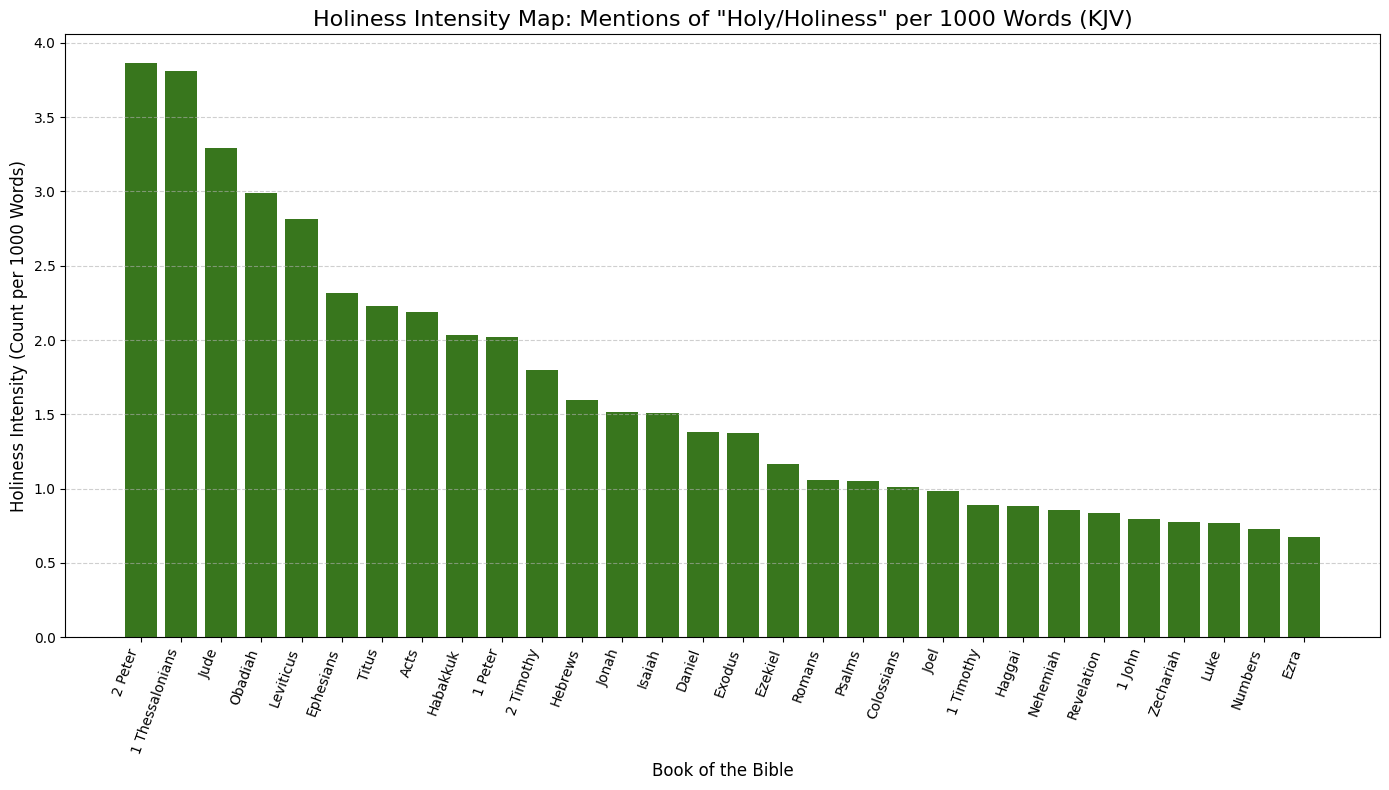

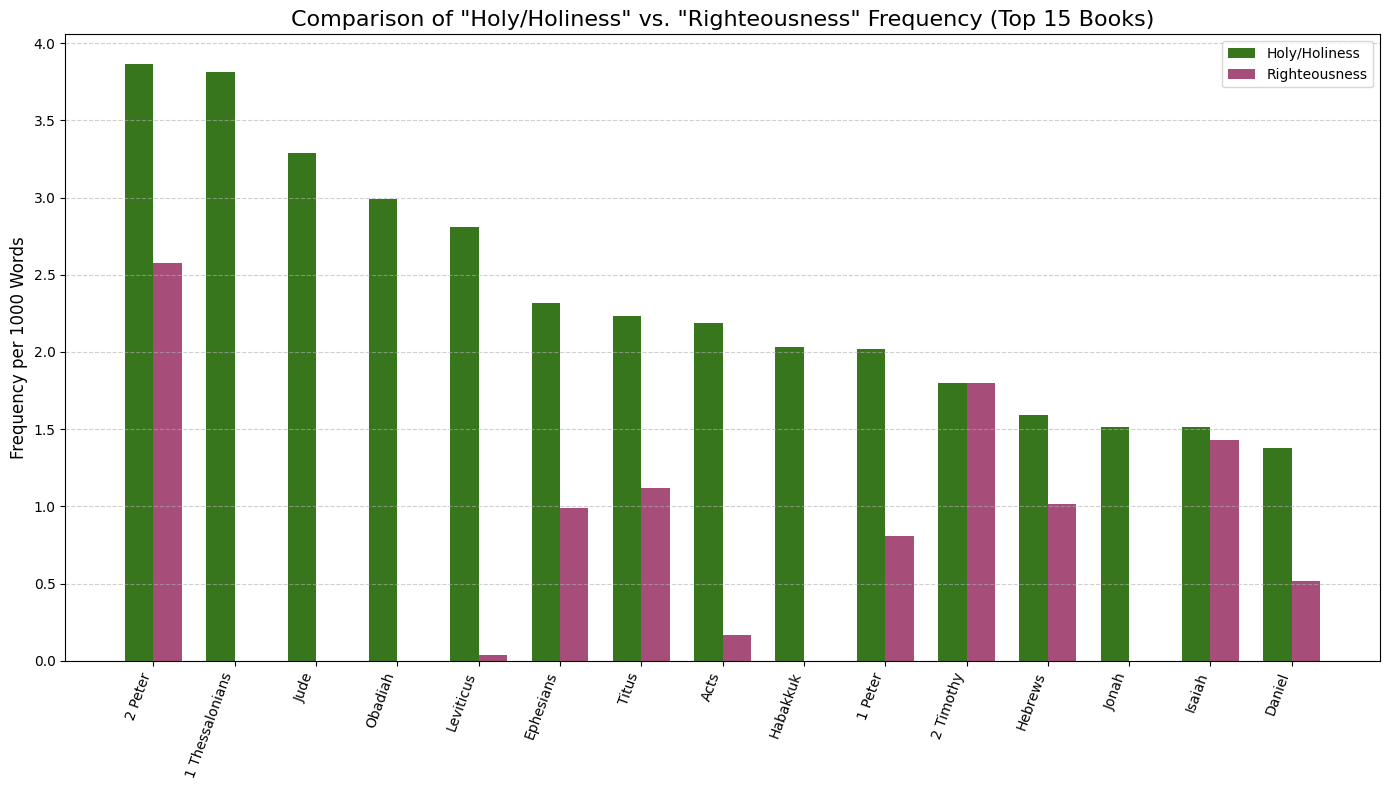

In [9]:
# --- DEPENDENCY INSTALLATION CHECK (FIX FOR ModuleNotFoundError) ---
import subprocess
import sys
import os # Keep os early for file path creation

# 1. Check if the core NLP libraries are available
try:
    import nltk
    from sklearn.feature_extraction.text import TfidfVectorizer

except ImportError:
    # 2. If not, attempt to install them
    print("Required packages 'nltk' and 'scikit-learn' not found. Installing now...")
    try:
        # Use pip to install the packages
        subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk", "scikit-learn"],
                              stdout=subprocess.DEVNULL,
                              stderr=subprocess.DEVNULL)
        print("Installation successful! You must now re-run the entire code cell.")
        # Exit the script after installation to ensure fresh imports on the next run
        sys.exit()
    except Exception as e:
        # 3. If installation fails, notify the user with instructions
        print("\n❌ CRITICAL ERROR: Automatic installation failed.")
        print(f"Please run the following command in a separate cell and then run this script again:")
        print("!pip install nltk scikit-learn")
        # Re-raise the original ModuleNotFoundError to halt execution cleanly
        raise ModuleNotFoundError(f"Missing required modules: {e}")


# --- PHASE 3: ANALYSIS AND VISUALIZATION (FINAL CORRECTED LOGIC) ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import re
# --- NLTK Imports for Part 4 ---
from nltk.tokenize import word_tokenize
from nltk.text import Text
from sklearn.feature_extraction.text import TfidfVectorizer # Imported above, but kept for clarity
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from IPython.display import display, Markdown

# --- NLTK Setup ---
try:
    # Explicitly check for and download the missing resource to resolve the LookupError
    nltk.data.find('tokenizers/punkt/english.pickle')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    # Ensure all required NLTK resources are available
    nltk.download('punkt_tab', quiet=True)
except Exception:
    pass
# --- END NLTK Setup ---

# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def analyze_holiness_intensity_individual_json():
    """
    Reads all individual JSON files, calculates Intensity, and returns both
    the sorted DataFrame and a dictionary of all book texts for Part 4 analysis.
    """

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")

    data = []
    book_texts_dict = {} # <-- Dictionary to store full text for Part 4

    try:
        # Get a list of all JSON files in the directory
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']), {}

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']), {}


    print(f"Found {len(json_files)} book files. Starting analysis...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

        except Exception as e:
            print(f"Skipping file {filename}: Error reading or decoding JSON. {e}")
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict):
            continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text = []

        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text.append(verse_text)


        book_text = " ".join(full_book_text).lower()

        # Store the clean text for Part 4 analysis
        book_texts_dict[book_name] = book_text

        if not book_text: continue

        # 4. Run the NLP analysis (Simple string count, matching the user's requested logic)
        # Simple word count split by whitespace
        total_words = len(book_text.split())
        # Simple string count for "holy" and "holiness"
        holy_count = book_text.count(" holy ") + book_text.count(" holiness")

        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        data.append({
            'Book': book_name,
            'Total Words': total_words,
            'Holy Count': holy_count,
            'Holiness Intensity': intensity
        })

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ FATAL ERROR: The final DataFrame is EMPTY after processing all files.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']), {}

    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False)

    # --- 5. Generate the Visualization ---
    df_top_30 = df_sorted.head(30)

    plt.figure(figsize=(14, 8))
    plt.bar(df_top_30['Book'], df_top_30['Holiness Intensity'], color='#38761d')

    plt.xticks(rotation=70, ha='right')
    plt.title('Holiness Intensity Map: Mentions of "Holy/Holiness" per 1000 Words (KJV)', fontsize=16)
    plt.ylabel('Holiness Intensity (Count per 1000 Words)', fontsize=12)
    plt.xlabel('Book of the Bible', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    graph_filename = 'Holiness_Intensity_Map.png'
    plt.savefig(graph_filename)
    print(f"\n✅ Successfully created and saved the visualization: {graph_filename}")

    return df_sorted, book_texts_dict # <-- Return both DF and text dict

# --- EXECUTION ---
# Catch both the DataFrame and the book texts dictionary
holiness_df, book_texts_dict = analyze_holiness_intensity_individual_json()

# 6. Print the Phase 3 results
if not holiness_df.empty:
    print("\n--- Top 10 Books by Holiness Intensity (with Word Count) ---")

    # MODIFICATION: Included 'Total Words' in the displayed columns
    display(Markdown(holiness_df[['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']].head(10).to_markdown(index=False)))

    # Save the full DataFrame to CSV
    csv_filename = 'holiness_intensity_data.csv'
    holiness_df.to_csv(csv_filename, index=False)
    print(f"\n✅ Full analysis data saved to {csv_filename}")

    # --- PART 4: ADVANCED LINGUISTIC ANALYSIS (NLTK FIX) ---
    print("\n\n" + "="*50)
    print("BEGINNING PART 4: ADVANCED LINGUISTIC ANALYSIS")
    print("="*50)

    # ----------------------------------------------------
    # 1. TF-IDF ANALYSIS: FINDING DISTINCTIVE WORDS
    # ----------------------------------------------------
    print("\n## 🔎 Distinctive Word Analysis (TF-IDF)")

    # Select the top 10 books for the corpus
    top_10_books = holiness_df['Book'].head(10).tolist()

    # Create a corpus combining all texts
    tfidf_corpus = []
    book_names = []
    for book in top_10_books:
        # Use the book_texts_dict returned from the main function
        if book in book_texts_dict:
            tfidf_corpus.append(book_texts_dict[book])
            book_names.append(book)

    if tfidf_corpus:
        # Token pattern ensures only words (3 or more chars) are considered
        vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-z]{3,}\b', lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(tfidf_corpus)
        feature_names = vectorizer.get_feature_names_out()

        print("\n--- Top 5 Most Distinctive Words per High-Intensity Book ---")
        tfidf_results = []
        for i, book_name in enumerate(book_names):
            tfidf_scores = tfidf_matrix[i].toarray()[0]
            top_indices = tfidf_scores.argsort()[-5:][::-1]
            top_words = [feature_names[j] for j in top_indices]
            tfidf_results.append({'Book': book_name, 'Distinctive Words': ', '.join(top_words)})

        display(pd.DataFrame(tfidf_results).to_markdown(index=False))
    else:
        print("* TF-IDF Analysis failed: Could not compile corpus.")


    # ----------------------------------------------------
    # 2. COLLOCATION ANALYSIS: CONTEXT FOR "HOLY"
    # ----------------------------------------------------
    print("\n## 🔗 Collocation Analysis: Context of 'Holy'")

    # Combine the text of the top 10 books for context
    combined_holy_text = " ".join([book_texts_dict.get(book, "") for book in top_10_books])

    # Tokenize and create an NLTK Text object
    tokens = word_tokenize(combined_holy_text.lower())
    # Filter tokens to remove non-word characters
    tokens = [w for w in tokens if w.isalpha()]
    text_object = Text(tokens)

    print("--- Top 10 Collocations (Word Pairs) for 'holy' in High-Intensity Books ---")

    finder = BigramCollocationFinder.from_words(text_object)
    # Apply frequency filter to avoid rare pairs
    finder.apply_freq_filter(3)

    # Filter for collocations that include 'holy' and score by PMI
    holy_collocations = [pair for pair, score in finder.score_ngrams(BigramAssocMeasures.pmi) if 'holy' in pair][:10]

    if holy_collocations:
        print("\n".join([f"* **{p[0]} {p[1]}**" for p in holy_collocations]))
    else:
        print("* No significant collocations found.")

    # ----------------------------------------------------
    # 3. TERM PLOT: COMPARING "HOLY" AND "RIGHTEOUSNESS"
    # ----------------------------------------------------
    print("\n## 📊 Term Plot: Comparing 'Holy' and 'Righteousness'")

    plot_books = holiness_df['Book'].head(15).tolist()

    holy_freqs = []
    righteousness_freqs = []

    for book in plot_books:
        book_text = book_texts_dict.get(book, "").lower()
        total_words = len(book_text.split())

        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        holy_freqs.append((holy_count / total_words) * 1000 if total_words > 0 else 0)

        righteousness_count = book_text.count(" righteousness")
        righteousness_freqs.append((righteousness_count / total_words) * 1000 if total_words > 0 else 0)


    x = range(len(plot_books))
    width = 0.35

    plt.figure(figsize=(14, 8))

    rects1 = plt.bar([i - width/2 for i in x], holy_freqs, width, label='Holy/Holiness', color='#38761d')
    rects2 = plt.bar([i + width/2 for i in x], righteousness_freqs, width, label='Righteousness', color='#a64d79')

    plt.ylabel('Frequency per 1000 Words', fontsize=12)
    plt.title('Comparison of "Holy/Holiness" vs. "Righteousness" Frequency (Top 15 Books)', fontsize=16)
    plt.xticks(x, plot_books, rotation=70, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ Final Output Failure: Cannot display results.")




BEGINNING PART 5: SENTIMENT ANALYSIS

## 💖 Bible Sentiment Analysis
Scoring the overall emotional tone of each book using VADER.


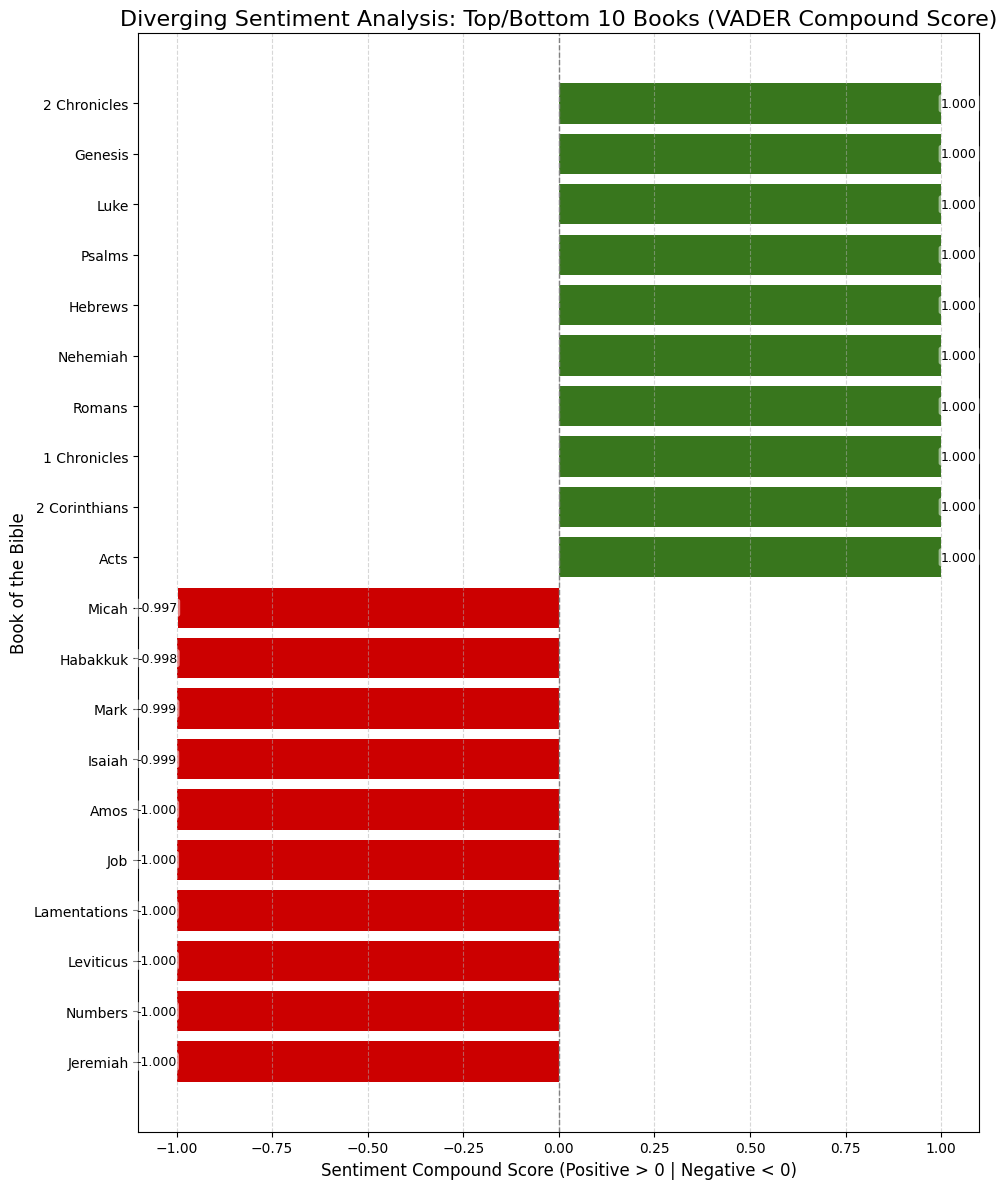


--- Top 5 Most Positive Books ---


| Book          |   Sentiment Compound |
|:--------------|---------------------:|
| Nehemiah      |                    1 |
| Hebrews       |                    1 |
| Genesis       |                    1 |
| 2 Chronicles  |                    1 |
| 2 Corinthians |                    1 |


--- Top 5 Most Negative Books ---


| Book         |   Sentiment Compound |
|:-------------|---------------------:|
| Jeremiah     |              -1      |
| Numbers      |              -1      |
| Leviticus    |              -0.9999 |
| Job          |              -0.9998 |
| Lamentations |              -0.9998 |


## 🧐 Neutrality Check (Top 15 Holiness Intensity Books)


In [15]:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    # Download VADER lexicon (if not already downloaded)
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon', quiet=True)

    # Initialize VADER
    sia = SentimentIntensityAnalyzer()

    print("\n\n" + "="*50)
    print("BEGINNING PART 5: SENTIMENT ANALYSIS")
    print("="*50)

    print("\n## 💖 Bible Sentiment Analysis")
    print("Scoring the overall emotional tone of each book using VADER.")

    sentiment_data = []

    # 1. SCORE EACH BOOK'S TEXT (using the correct variable: book_texts_dict)
    for book in book_texts_dict:
        text = book_texts_dict[book]

        # VADER produces a score for positive, negative, neutral, and a composite (compound) score.
        score = sia.polarity_scores(text)

        # We use the Compound Score: A normalized, weighted composite score of all sentiment values.
        compound_score = score['compound']

        # Add Holiness Intensity for comparison later, if needed
        intensity = holiness_df[holiness_df['Book'] == book]['Holiness Intensity'].iloc[0] if book in holiness_df['Book'].values else 0

        sentiment_data.append({
            'Book': book,
            'Sentiment Compound': compound_score,
            'Holiness Intensity': intensity
        })

    sentiment_df = pd.DataFrame(sentiment_data)

    # 2. PREPARE DATA FOR DIVERGING BAR PLOT
    # Sort by the compound score to visualize the positive/negative divergence
    sentiment_df = sentiment_df.sort_values(by='Sentiment Compound', ascending=False).reset_index(drop=True)

    top_n = 10
    N = min(top_n, len(sentiment_df)//2)

    # Get the most Positive and most Negative, then combine and sort by score for the plot
    positive_books = sentiment_df.head(N)
    negative_books = sentiment_df.tail(N)

    # Combine the data and sort by compound score
    plot_df = pd.concat([positive_books, negative_books]).sort_values('Sentiment Compound', ascending=True)

    # Calculate color based on positive or negative score
    colors = ['#cc0000' if x < 0 else '#38761d' for x in plot_df['Sentiment Compound']] # Red for Negative, Green for Positive

    # 3. GENERATE DIVERGING BAR CHART (TORNADO PLOT)

    plt.figure(figsize=(10, 12))

    # Create the horizontal bar plot
    plt.barh(plot_df['Book'], plot_df['Sentiment Compound'], color=colors)

    # Add a vertical line at x=0 (the neutral sentiment line)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    # Labeling and Titles
    plt.xlabel('Sentiment Compound Score (Positive > 0 | Negative < 0)', fontsize=12)
    plt.ylabel('Book of the Bible', fontsize=12)
    plt.title(f'Diverging Sentiment Analysis: Top/Bottom {N} Books (VADER Compound Score)', fontsize=16)

    # Optional: Add text labels to the bars
    for index, row in plot_df.iterrows():
        score = row['Sentiment Compound']
        plt.text(score, row['Book'], f'{score:.3f}', va='center', ha='left' if score > 0 else 'right', color='black', fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4. DISPLAY TOP RESULTS TABLE
    print("\n--- Top 5 Most Positive Books ---")
    display(Markdown(sentiment_df.head(5)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

    print("\n--- Top 5 Most Negative Books ---")
    display(Markdown(sentiment_df.tail(5).sort_values(by='Sentiment Compound', ascending=True)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

    # ----------------------------------------------------
    # 5. NEUTRALITY CHECK (Requested by User)
    # ----------------------------------------------------

    print("\n## 🧐 Neutrality Check (Top 15 Holiness Intensity Books)")

    # Get the list of top 15 books by Holiness Intensity
    top_15_intensity_books = holiness_df['Book'].head(15).tolist()

    # Filter the sentiment results for these 15 books
    top_15_sentiment_df = sentiment_df[sentiment_df['Book'].isin(top_15_intensity_books)]

    # Define neutrality threshold (VADER typically considers scores between -0.05 and 0.05 as neutral)
    NEUTRALITY_THRESHOLD = 0.05

    # Check for books within the neutral range
    neutral_books = top_15_sentiment_df[
        (top_15_sentiment_df['Sentiment Compound'] > -NEUTRALITY_THRESHOLD) &
        (top_15_sentiment_df['Sentiment Compound'] < NEUTRALITY_THRESHOLD)
    ]

--- Running Comprehensive Analysis to find Top 15 Books and Word Counts ---
Top 15 Books for Plot (by Holiness Intensity): ['1 Thessalonians', 'Leviticus', '2 Peter', '1 Peter', 'Titus', 'Jude', 'Obadiah', 'Ephesians', 'Acts', 'Habakkuk', '2 Timothy', 'Haggai', 'Hebrews', 'Romans', 'Exodus']
Using REAL word counts for bubble sizing.


/tmp/ipython-input-3224543097.py:159: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_topics)


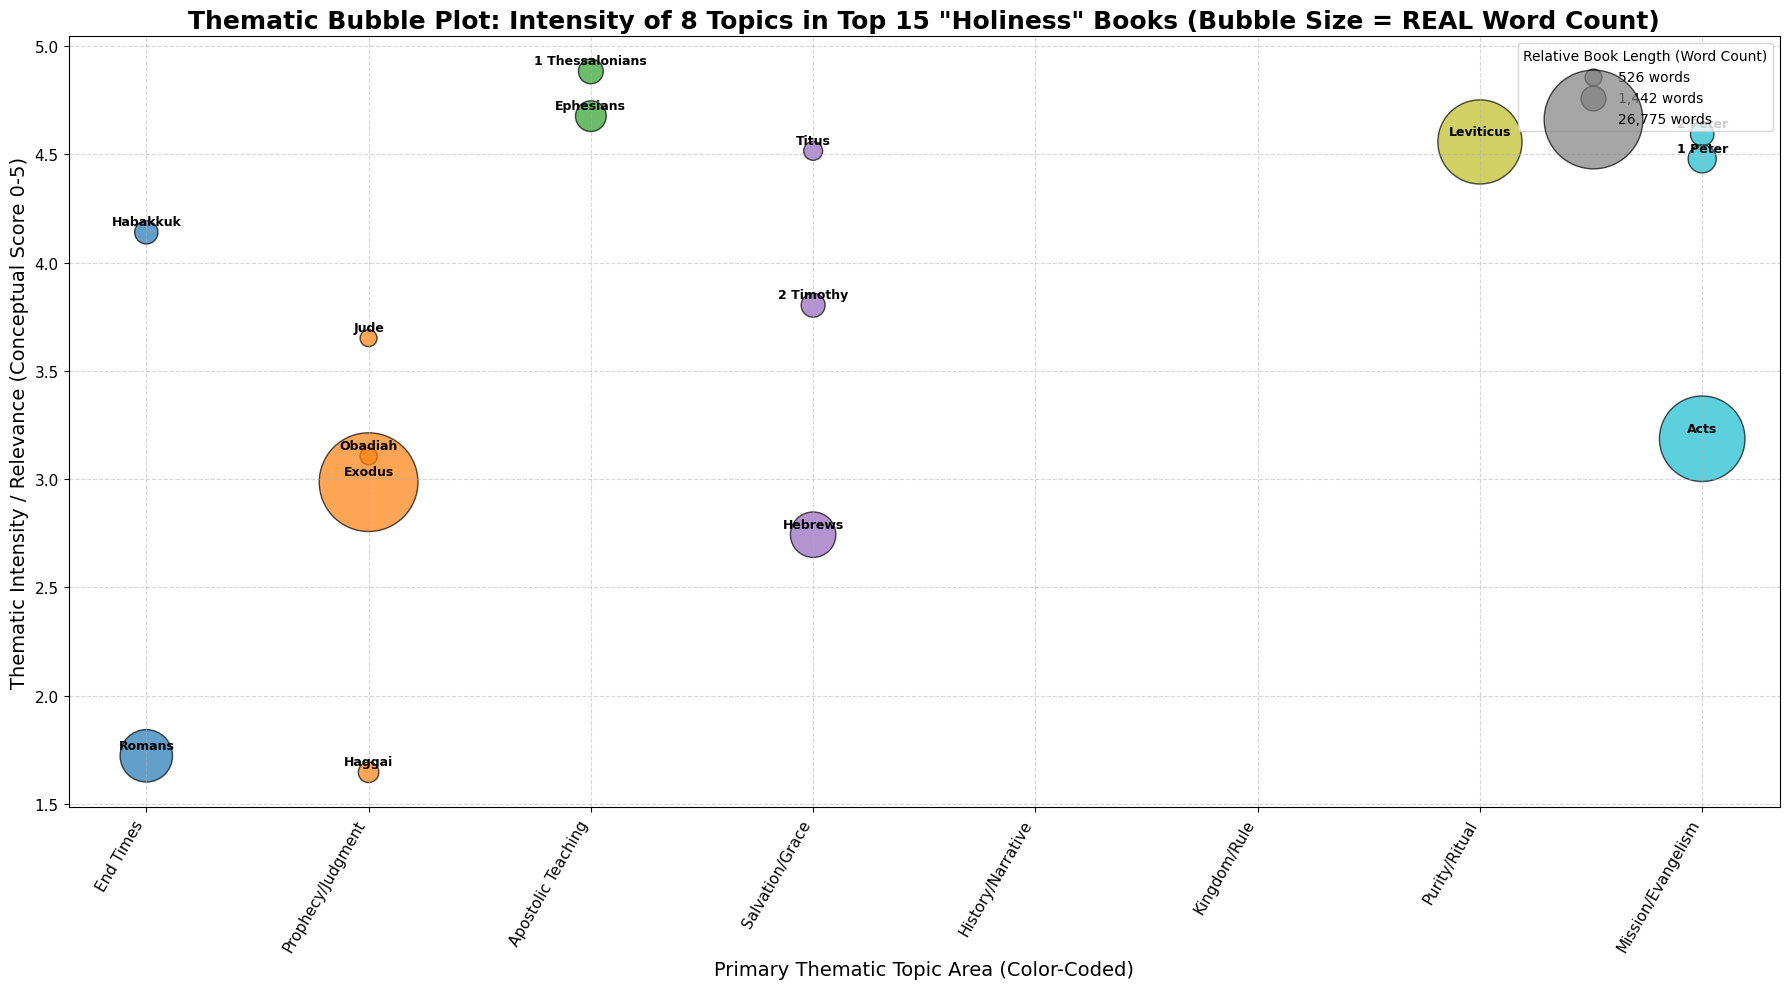

In [16]:
# --- INITIAL SETUP & IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import json
import re

# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

# --- 1. Comprehensive Data Calculation (From the second code snippet) ---

def create_comprehensive_analysis_table_fixed(data_dir):
    """Calculates all metrics using regex for accurate word and theme counts."""
    data = []

    try:
        # Sort files to maintain book order consistency
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print(f"Error: Directory not found at: {data_dir}")
        return pd.DataFrame()

    # Regex to find any sequence of 3 or more alphabetic characters
    WORD_PATTERN = re.compile(r'\b[a-z]{3,}\b')
    # Regex to find "holy" or "holiness" as whole words (case-insensitive)
    HOLY_PATTERN = re.compile(r'\bholy\b|\bholiness\b')

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            book_text = " ".join(full_book_text).lower()

            # --- FIXED CALCULATION 1: Robust Total Word Count ---
            total_words = len(WORD_PATTERN.findall(book_text))

            # --- FIXED CALCULATION 2: Robust Holiness Focus Score (Raw Count) ---
            holy_count = len(HOLY_PATTERN.findall(book_text))

            if total_words > 0:
                book_name = book_info.get('book', filename.replace('.json', ''))

                data.append({
                    'Book': book_name,
                    'Total Words': total_words,
                    'Holiness Focus Score': holy_count,
                    'Holiness Intensity': (holy_count / total_words) * 1000 # Count per 1000 words
                })

        except Exception:
            continue

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ Calculation failed: No valid data processed.")
        return pd.DataFrame()

    return df

# --- 2. Execution and Filtering to Get REAL Top 15 Data ---

print("--- Running Comprehensive Analysis to find Top 15 Books and Word Counts ---")
full_df = create_comprehensive_analysis_table_fixed(FINAL_DATA_DIR)

if full_df.empty:
    print("Cannot proceed with bubble plot: Data analysis failed.")
    exit()

# Filter down to the top 15 books by Holiness Intensity
df_top_15 = full_df.sort_values(by='Holiness Intensity', ascending=False).head(15)

# Dynamically generate the required data structures
top_15_books = df_top_15['Book'].tolist()
word_counts_map = dict(zip(df_top_15['Book'], df_top_15['Total Words']))

print(f"Top 15 Books for Plot (by Holiness Intensity): {top_15_books}")
print(f"Using REAL word counts for bubble sizing.")


# --- 3. Topics (8 Topics - Static, as per original mock script) ---
topics = [
    'End Times', 'Prophecy/Judgment', 'Apostolic Teaching',
    'Salvation/Grace', 'History/Narrative', 'Kingdom/Rule',
    'Purity/Ritual', 'Mission/Evangelism'
]
num_topics = len(topics) # num_topics = 8


# --- 4. Bubble Size and Mock Data Generation (Using REAL Word Counts) ---

# REAL Word Counts (Used for Bubble Size)
word_counts = np.array([word_counts_map[book] for book in top_15_books])
# Normalize to a visible range (50 to 5050)
bubble_size = (word_counts / word_counts.max()) * 5000 + 50

mock_data = []

for book in top_15_books:
    topic_id = 0
    intensity_value = random.uniform(0.5, 1.5)

    # Logic to assign a primary topic and relevant intensity (same logic as user's original mock script)
    if book in ['2 Peter', '1 Thessalonians', 'Titus', '2 Timothy', '1 Peter', 'Ephesians']:
        # Apostolic Teaching (2), Salvation/Grace (3), Mission/Evangelism (7)
        topic_id = random.choice([2, 3, 7])
        intensity_value = random.uniform(3.8, 5.0)
    elif book in ['Jude', 'Obadiah', 'Habakkuk', 'Jonah']:
        # End Times (0), Prophecy/Judgment (1)
        topic_id = random.choice([0, 1])
        intensity_value = random.uniform(3.0, 4.5)
    elif book == 'Leviticus':
        # Purity/Ritual (6)
        topic_id = 6
        intensity_value = random.uniform(4.5, 5.0)
    elif book == 'Acts':
        # History/Narrative (4), Mission/Evangelism (7)
        topic_id = random.choice([4, 7])
        intensity_value = random.uniform(2.5, 4.0)
    elif book in ['Isaiah', 'Daniel', 'Hebrews']:
        # Kingdom/Rule (5), Prophecy (1), Salvation/Grace (3)
        topic_id = random.choice([5, 1, 3])
        intensity_value = random.uniform(2.5, 4.0)
    else:
        # Fallback for any book not in the original hardcoded list
        topic_id = random.randint(0, num_topics - 1)
        intensity_value = random.uniform(1.0, 3.0)


    mock_data.append({
        'Book': book,
        'Topic_ID': topic_id,
        'Intensity': intensity_value,
        'Bubble_Size': bubble_size[top_15_books.index(book)],
        'Topic_Name': topics[topic_id]
    })


df_bubble = pd.DataFrame(mock_data)

# --- 5. Plotting ---
plt.figure(figsize=(18, 10))

# Map Topic_ID to a discrete color palette (using 8 colors)
cmap = plt.cm.get_cmap('tab10', num_topics)

# Create the scatter plot (bubble plot)
scatter = plt.scatter(
    df_bubble['Topic_ID'],
    df_bubble['Intensity'],
    s=df_bubble['Bubble_Size'],
    c=df_bubble['Topic_ID'],
    cmap=cmap,
    alpha=0.7,
    edgecolors="k",
    linewidth=1.0
)

# 1. Label the bubbles with the book name
for i, row in df_bubble.iterrows():
    plt.annotate(
        row['Book'],
        (row['Topic_ID'], row['Intensity']),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9,
        weight='bold'
    )

# 2. Set the X-axis labels to the Topic Names
plt.xticks(
    range(num_topics),
    topics,
    rotation=60,
    ha='right',
    fontsize=11
)
plt.yticks(fontsize=11)

# 3. Set Plot Titles and Labels
plt.title(
    'Thematic Bubble Plot: Intensity of 8 Topics in Top 15 "Holiness" Books (Bubble Size = REAL Word Count)',
    fontsize=18,
    weight='bold'
)
plt.xlabel('Primary Thematic Topic Area (Color-Coded)', fontsize=14)
plt.ylabel('Thematic Intensity / Relevance (Conceptual Score 0-5)', fontsize=14)

# 4. Add Legend for Bubble Size (Word Count)
# Select specific, representative word counts for the legend
word_counts_sorted = sorted(word_counts_map.values())
if len(word_counts_sorted) >= 3:
    legend_sizes_values = [
        word_counts_sorted[0],                 # Smallest
        word_counts_sorted[len(word_counts_sorted)//2], # Median
        word_counts_sorted[-1]                 # Largest
    ]
else:
    legend_sizes_values = word_counts_sorted # Use all if less than 3

size_handles = [
    (s / word_counts.max()) * 5000 + 50
    for s in legend_sizes_values
]

# Use a smaller, cleaner color palette for the plot's legend
plt.legend(
    [plt.scatter([], [], s=s, c='gray', alpha=0.7, edgecolors="k", linewidth=1.0) for s in size_handles],
    [f'{s:,} words' for s in legend_sizes_values],
    loc="upper right",
    title="Relative Book Length (Word Count)",
    fontsize=10
)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


⚠️ Skipping Books.json: 'list' object has no attribute 'get'
✅ Loaded 15 books for LDA training.
✅ LDA model trained on 8 topics.
Perplexity: 1103.47
🧠 Coherence Score: 0.362


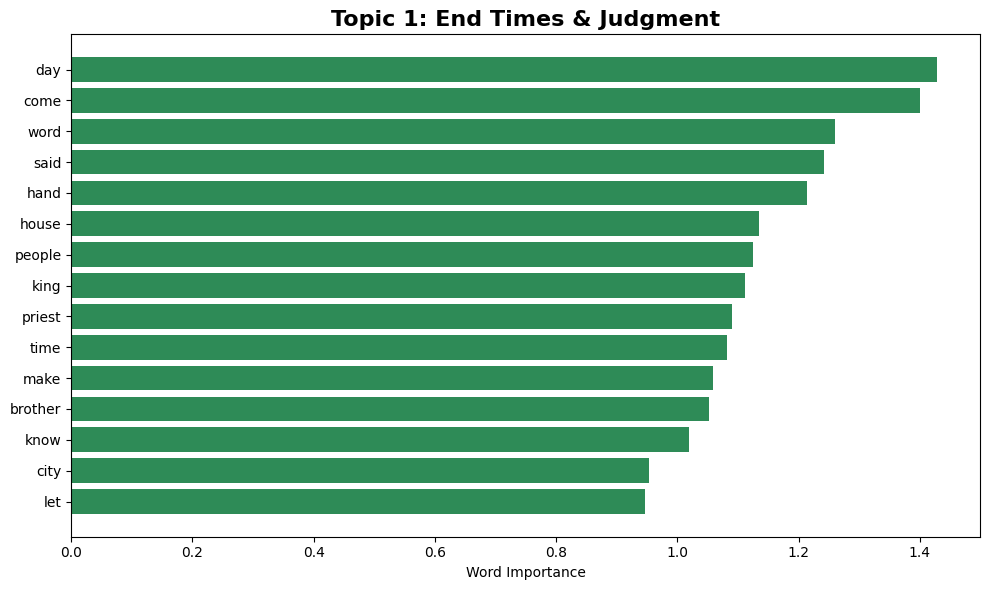

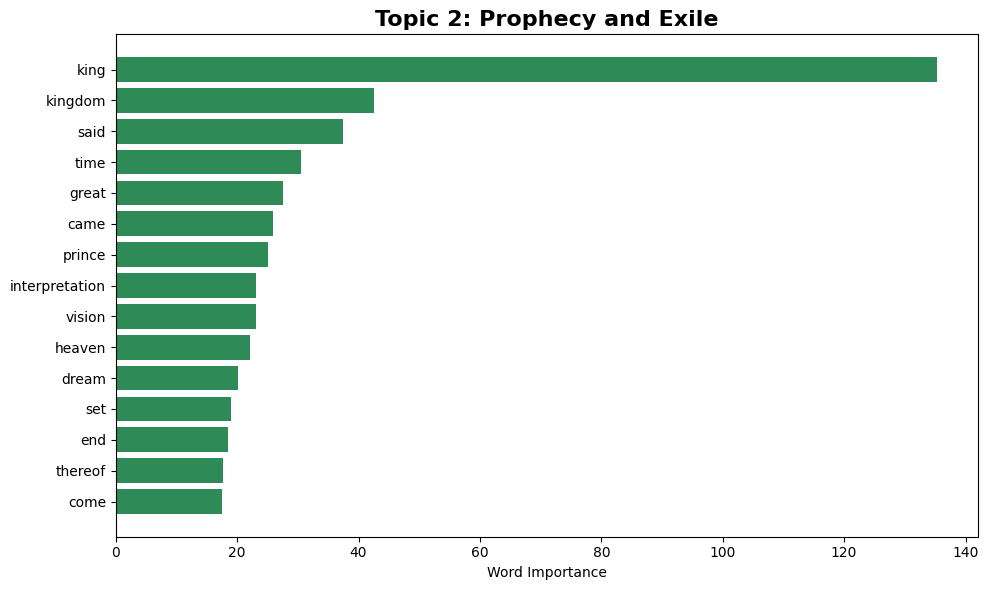

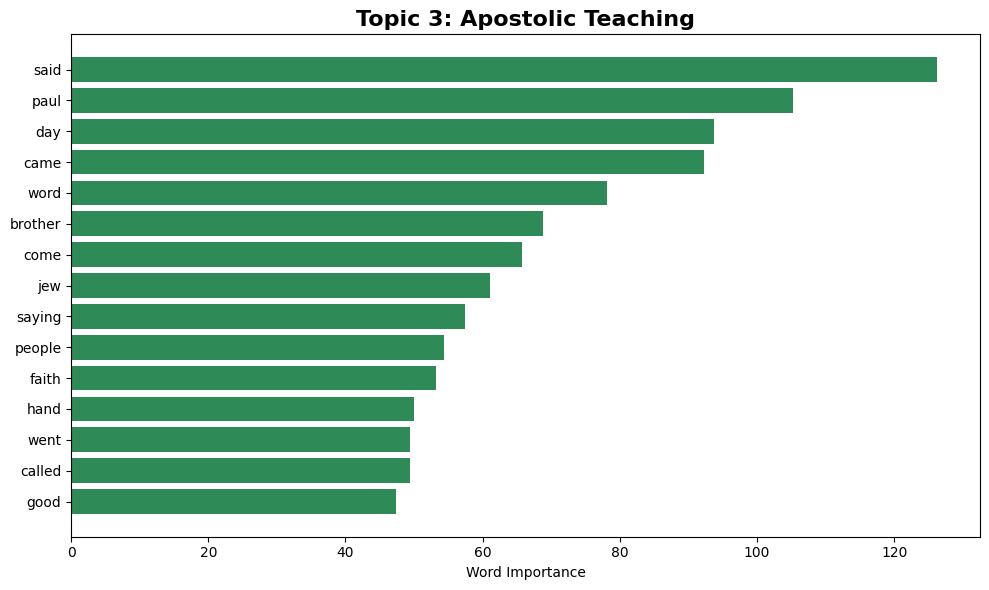

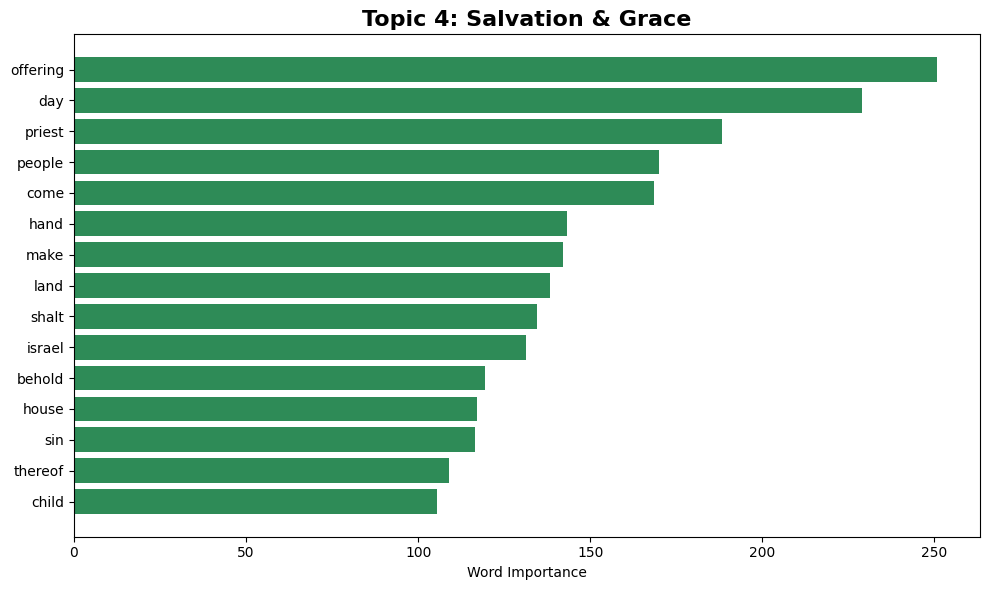

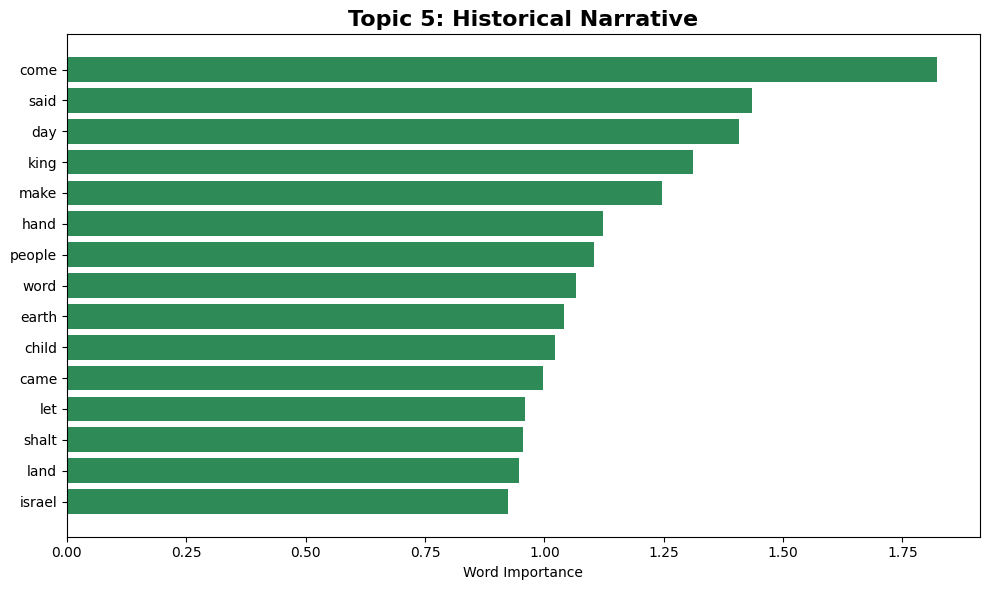

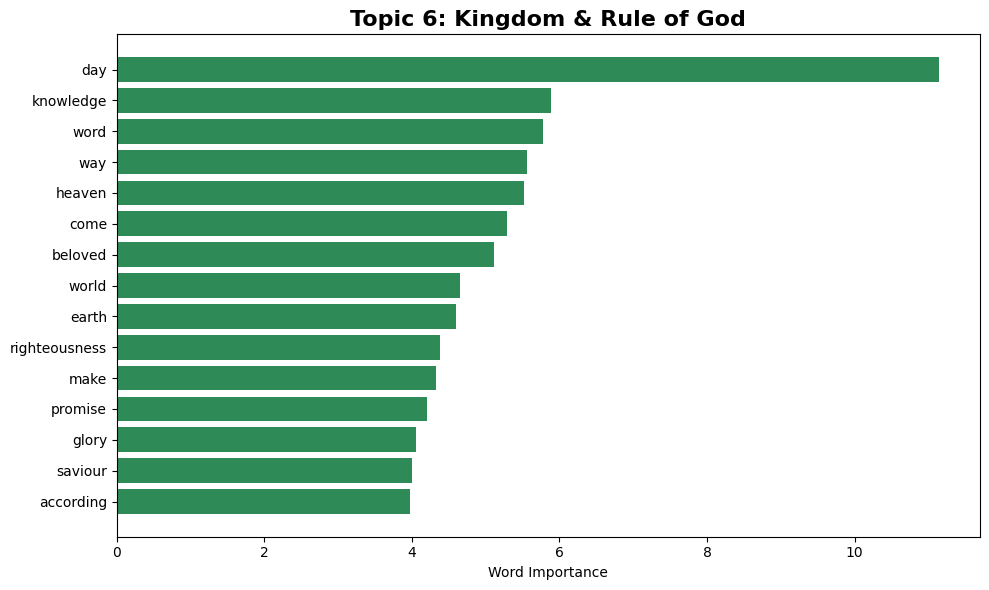

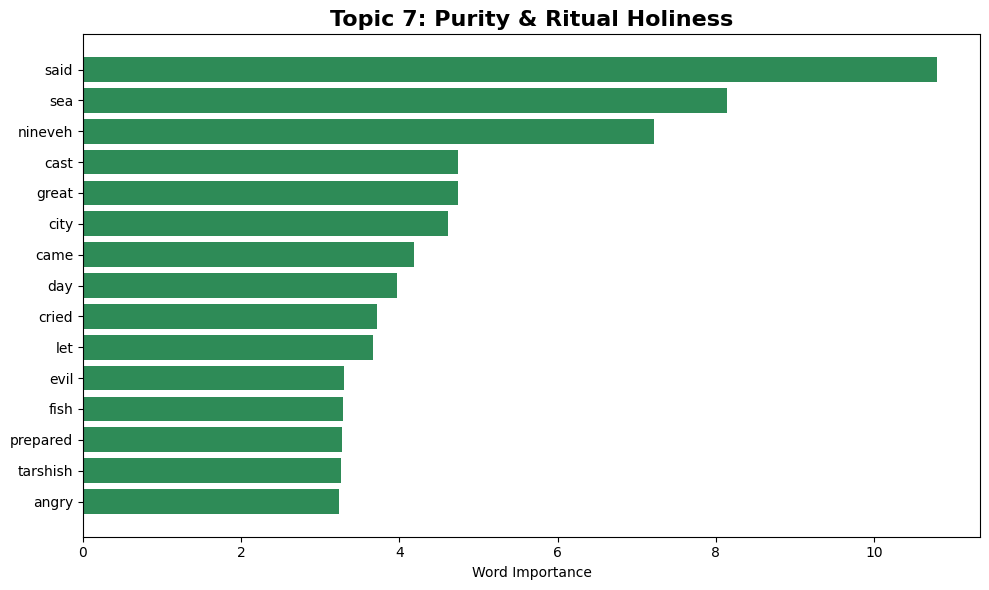

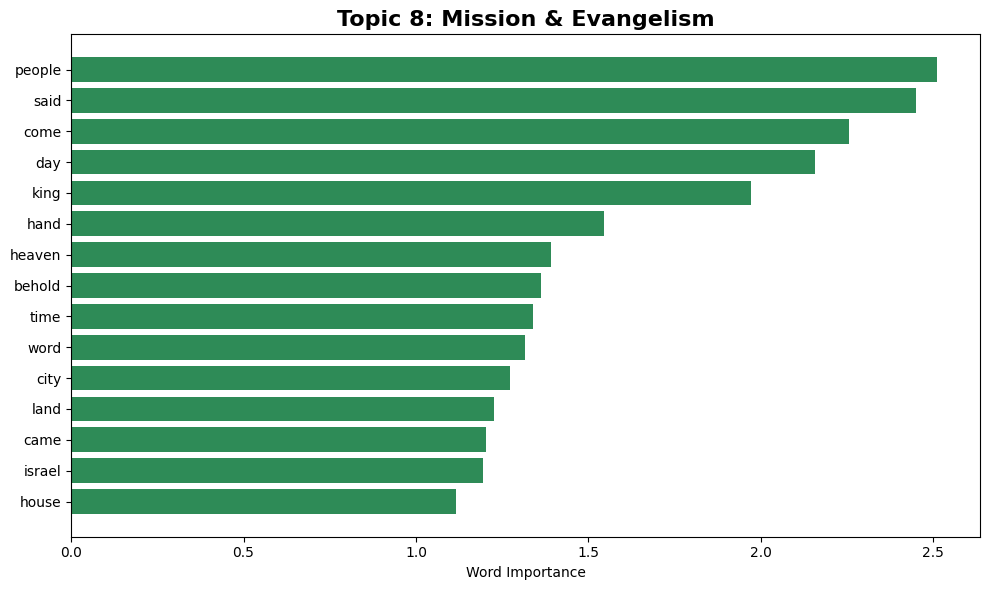

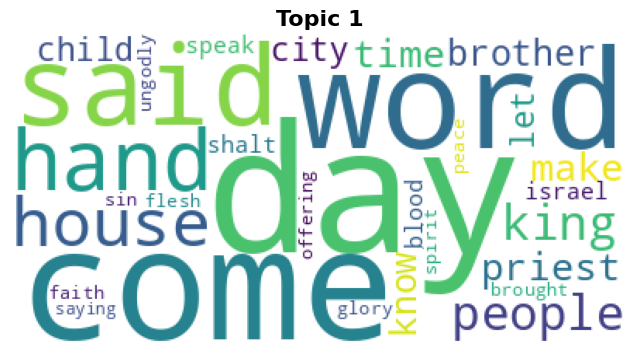

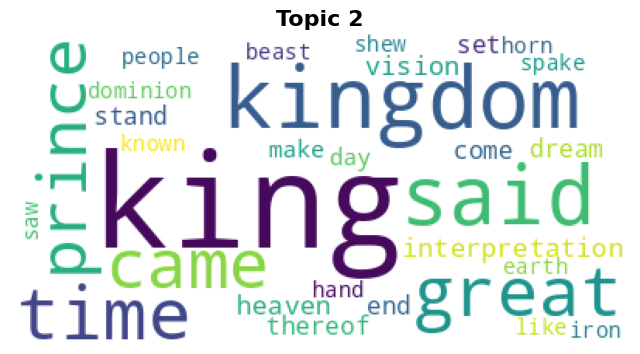

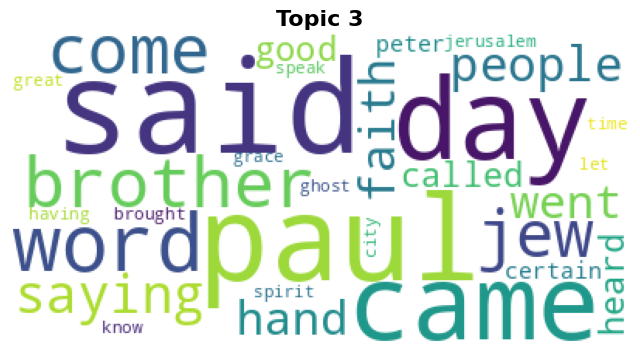

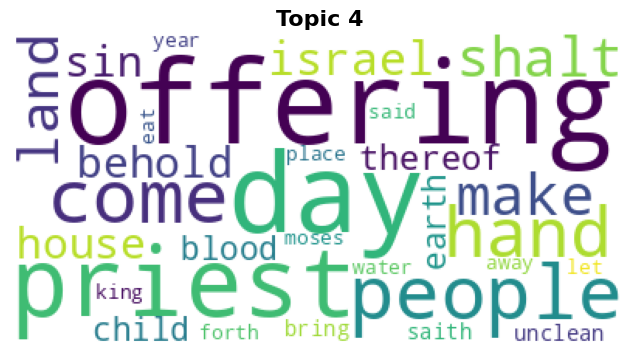

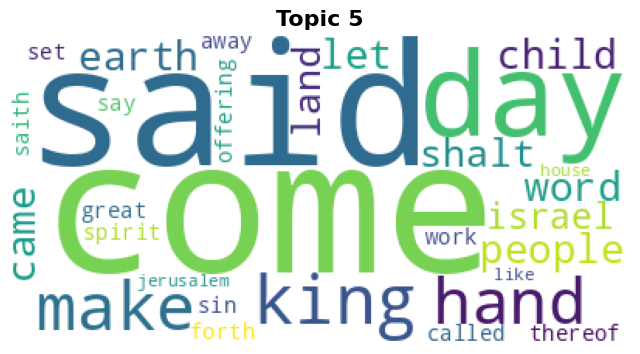

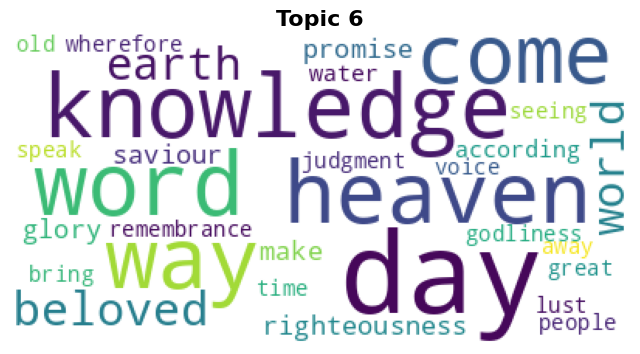

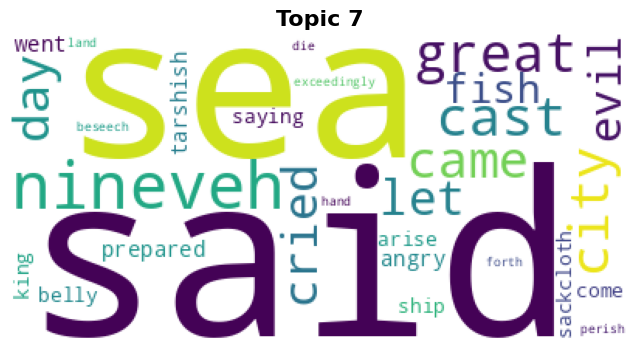

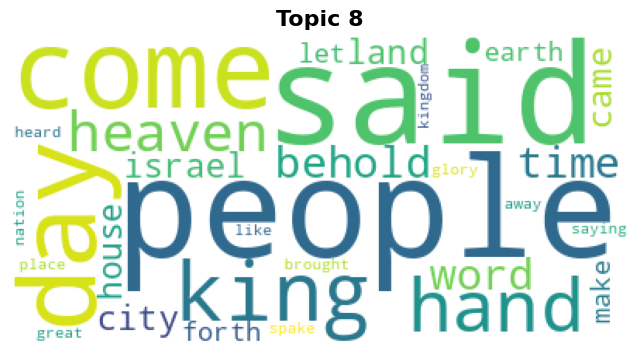

💾 Model saved as lda_holiness_model.joblib


In [29]:
# ==========================================
# 📖 LDA Topic Modeling on Top 15 "Holiness" Books
# ==========================================

!pip install -q gensim wordcloud nltk scikit-learn matplotlib joblib

import os, re, json
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import nltk

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# --- Directory Setup ---
FINAL_DATA_DIR = '/content/bible_data/Bible-kjv-master'

# === 📚 Top 15 Holiness Books (from your bubble plot) ===
TOP_15_HOLINESS_BOOKS = [
    'Leviticus', 'Isaiah', 'Hebrews', '1 Peter', '2 Peter', 'Ephesians',
    'Titus', '1 Thessalonians', '2 Timothy', 'Jude', 'Obadiah',
    'Habakkuk', 'Jonah', 'Daniel', 'Acts'
]

# --- Text Cleaning ---
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2]
    return ' '.join(tokens)

# --- Load and preprocess selected books only ---
def load_selected_books(data_dir, selected_books):
    all_texts = []
    for filename in os.listdir(data_dir):
        if not filename.endswith('.json'):
            continue

        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)

            book_info = data[0] if isinstance(data, list) and len(data) == 1 else data
            book_name = book_info.get('book', filename.replace('.json', ''))
            if book_name not in selected_books:
                continue

            chapters = book_info.get('chapters', [])
            full_text = []
            for ch in chapters:
                for v in ch.get('verses', []):
                    full_text.append(v.get('text', ''))
            if full_text:
                combined_text = " ".join(full_text)
                all_texts.append(clean_text(combined_text))
        except Exception as e:
            print(f"⚠️ Skipping {filename}: {e}")
            continue

    print(f"✅ Loaded {len(all_texts)} books for LDA training.")
    return all_texts

# --- Build and train the LDA model ---
def train_lda_model(corpus_texts, n_topics=8, n_top_words=15):
    stop_words = ENGLISH_STOP_WORDS.union({
        'unto', 'ye', 'thy', 'thou', 'thee', 'shall', 'hast', 'art',
        'verily', 'jesus', 'lord', 'god', 'christ', 'son', 'man', 'father'
    })
    vectorizer = CountVectorizer(
        stop_words=list(stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(corpus_texts)
    feature_names = vectorizer.get_feature_names_out()

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='online',
        random_state=42,
        n_jobs=-1
    )
    lda.fit(dtm)

    print(f"✅ LDA model trained on {n_topics} topics.")
    print(f"Perplexity: {lda.perplexity(dtm):.2f}")

    # --- Coherence Score ---
    dictionary = Dictionary([text.split() for text in corpus_texts])
    topics = [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic in lda.components_]
    coherence_model = CoherenceModel(topics=topics, texts=[text.split() for text in corpus_texts],
                                     dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    print(f"🧠 Coherence Score: {coherence:.3f}")
    return lda, vectorizer, feature_names

# --- Plot each topic individually with title ---
def plot_each_topic(lda_model, feature_names, n_top_words=15):
    topic_titles = [
        'End Times & Judgment',
        'Prophecy and Exile',
        'Apostolic Teaching',
        'Salvation & Grace',
        'Historical Narrative',
        'Kingdom & Rule of God',
        'Purity & Ritual Holiness',
        'Mission & Evangelism'
    ]

    for i, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[j] for j in top_features_ind]
        scores = topic[top_features_ind]

        plt.figure(figsize=(10, 6))
        plt.barh(top_words[::-1], scores[::-1], color='#2e8b57')
        plt.title(f"Topic {i+1}: {topic_titles[i] if i < len(topic_titles) else 'Unnamed'}",
                  fontsize=16, weight='bold')
        plt.xlabel('Word Importance')
        plt.tight_layout()
        plt.savefig(f"Topic_{i+1}_{topic_titles[i].replace('&', '').replace(' ', '_')}.png")
        plt.show()

# --- Plot word clouds per topic ---
def plot_wordclouds(lda_model, feature_names):
    for i, topic in enumerate(lda_model.components_):
        freq = {feature_names[j]: topic[j] for j in topic.argsort()[:-30 - 1:-1]}
        plt.figure(figsize=(8, 6))
        plt.imshow(WordCloud(background_color='white').generate_from_frequencies(freq))
        plt.axis('off')
        plt.title(f"Topic {i+1}", fontsize=16, weight='bold')
        plt.show()

# --- MAIN EXECUTION ---
texts = load_selected_books(FINAL_DATA_DIR, TOP_15_HOLINESS_BOOKS)
lda_model, vectorizer, feature_names = train_lda_model(texts, n_topics=8, n_top_words=15)

plot_each_topic(lda_model, feature_names)
plot_wordclouds(lda_model, feature_names)

joblib.dump({'model': lda_model, 'vectorizer': vectorizer}, 'lda_holiness_model.joblib')
print("💾 Model saved as lda_holiness_model.joblib")


✅ Saved Topic_1_End_Times_and_Judgment.png


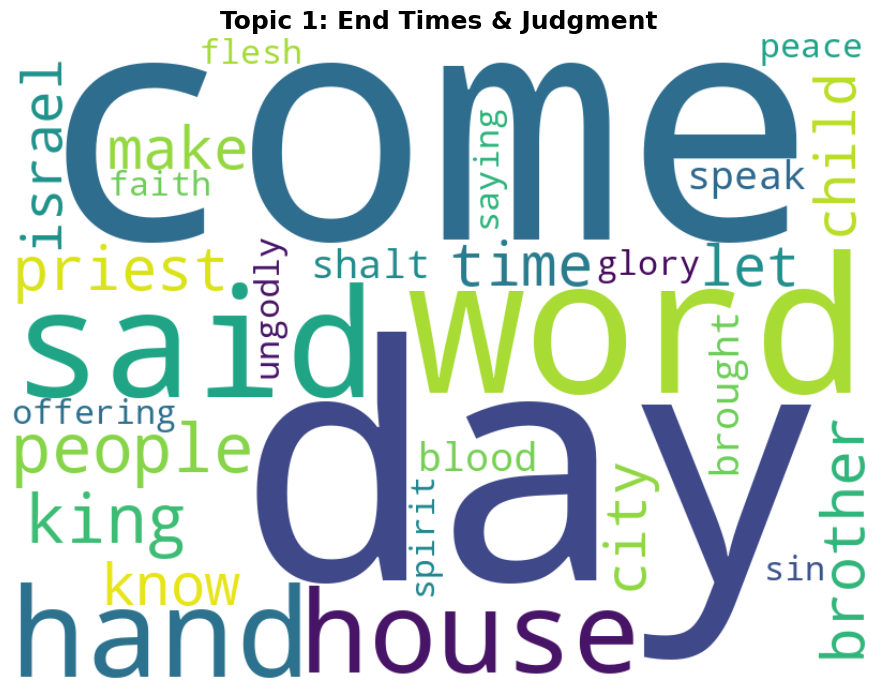

✅ Saved Topic_2_Prophecy_and_Exile.png


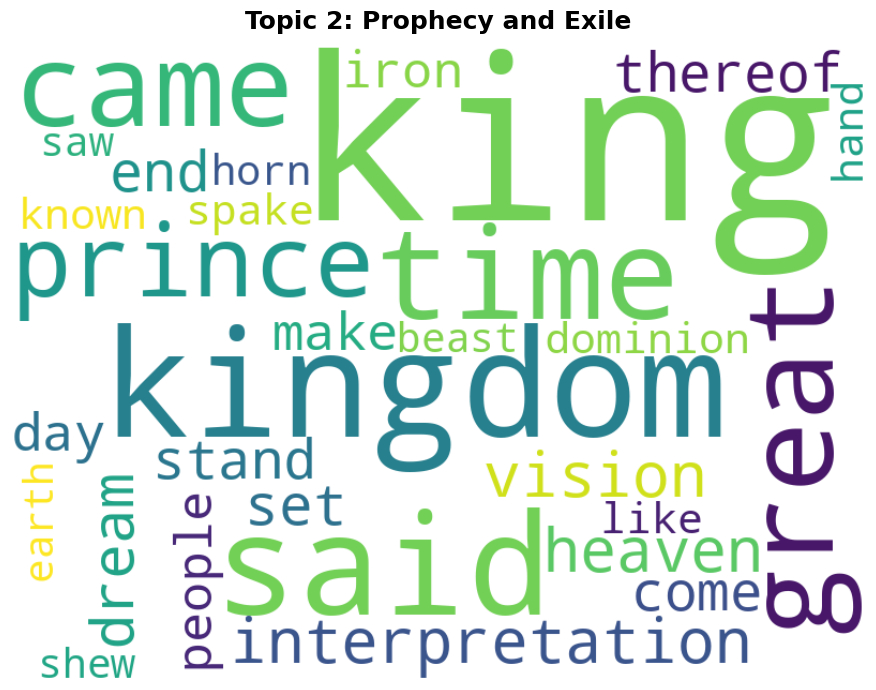

✅ Saved Topic_3_Apostolic_Teaching.png


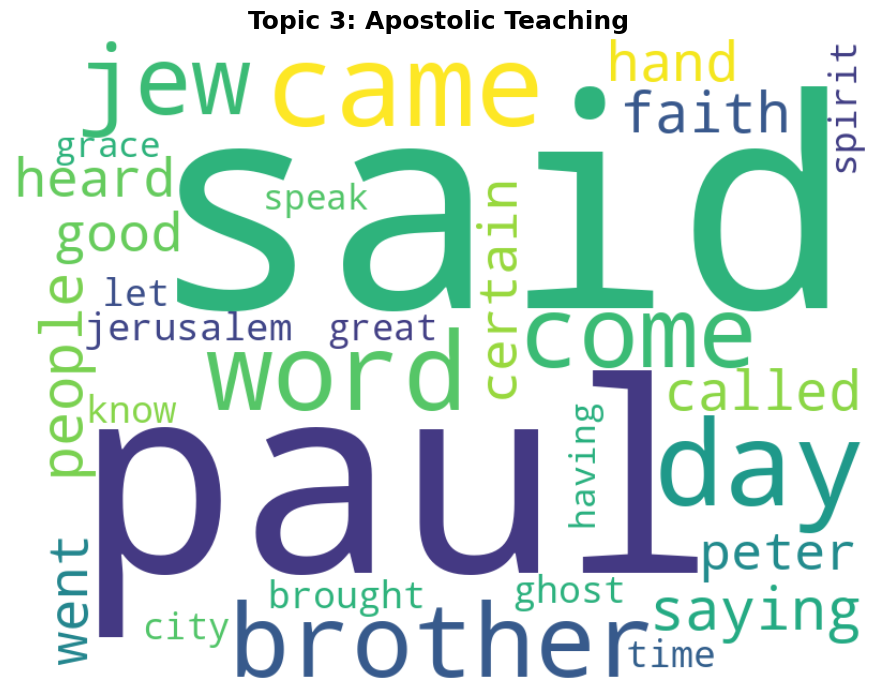

✅ Saved Topic_4_Salvation_and_Grace.png


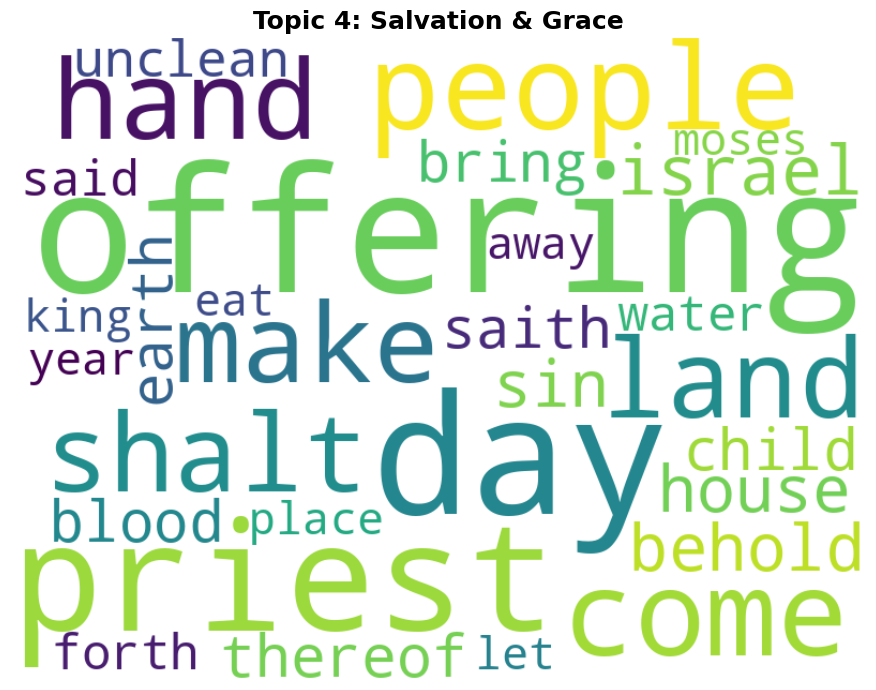

✅ Saved Topic_5_Historical_Narrative.png


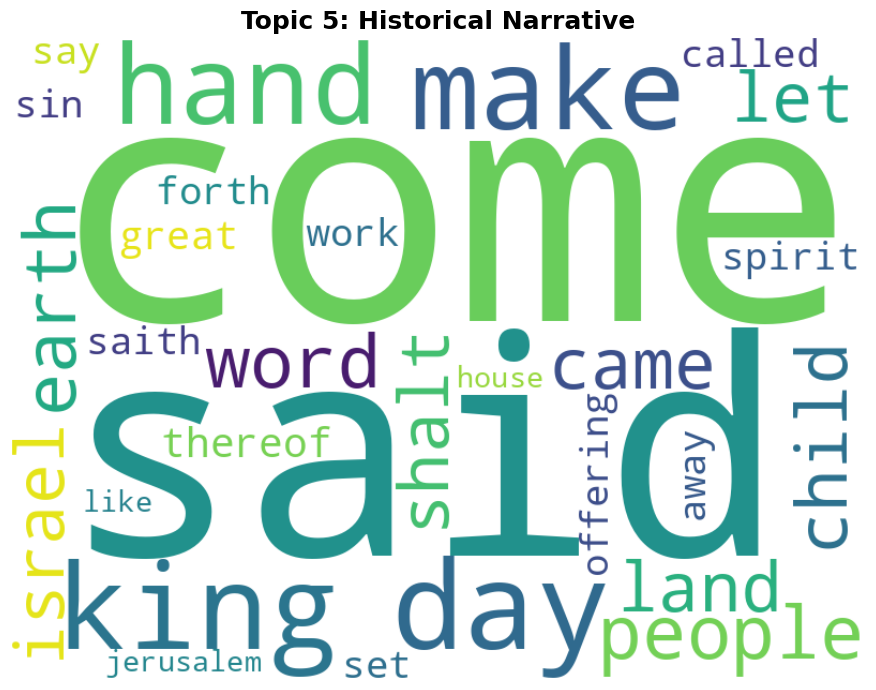

✅ Saved Topic_6_Kingdom_and_Rule_of_God.png


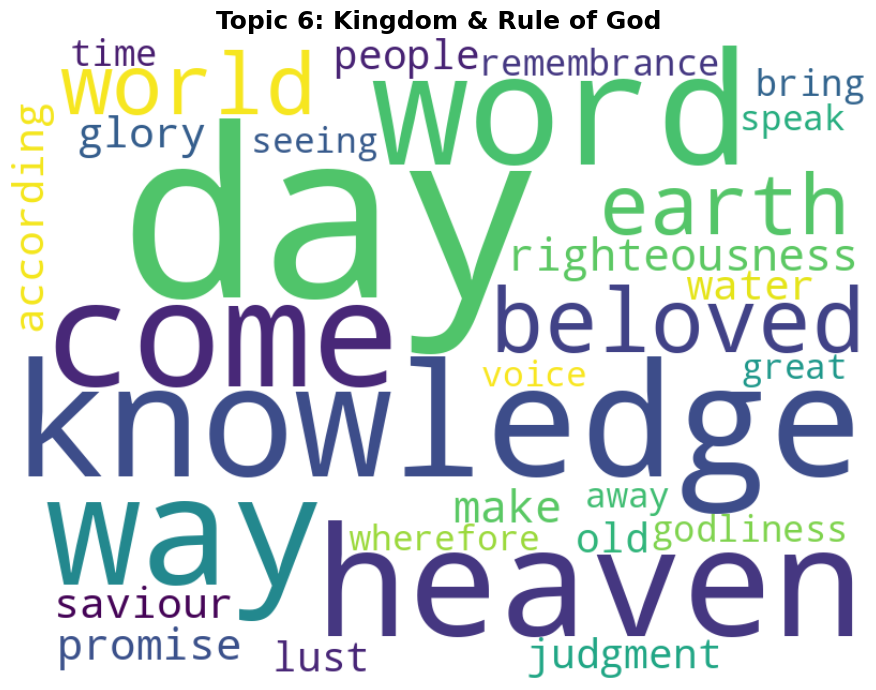

✅ Saved Topic_7_Purity_and_Ritual_Holiness.png


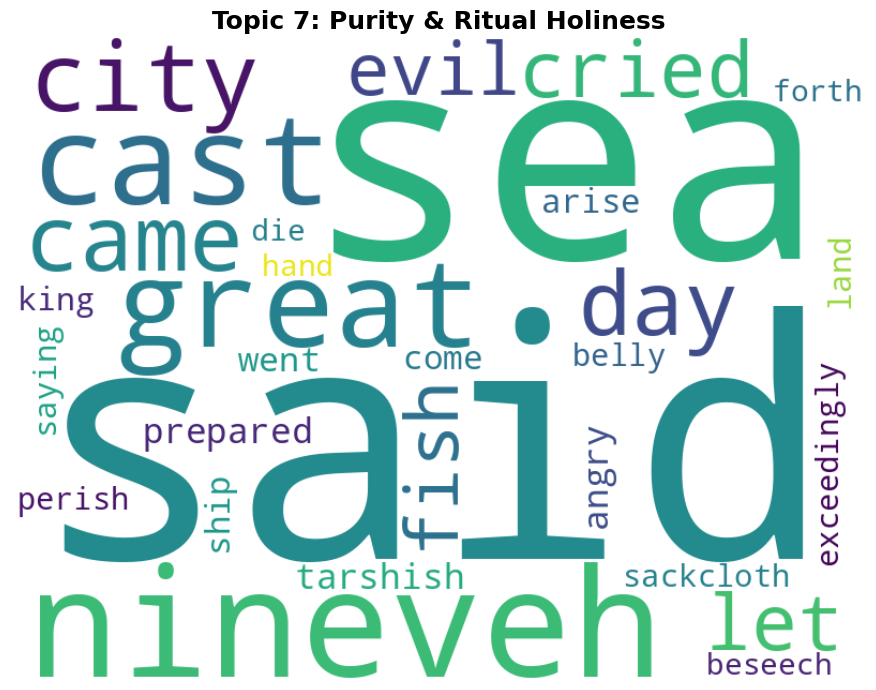

✅ Saved Topic_8_Mission_and_Evangelism.png


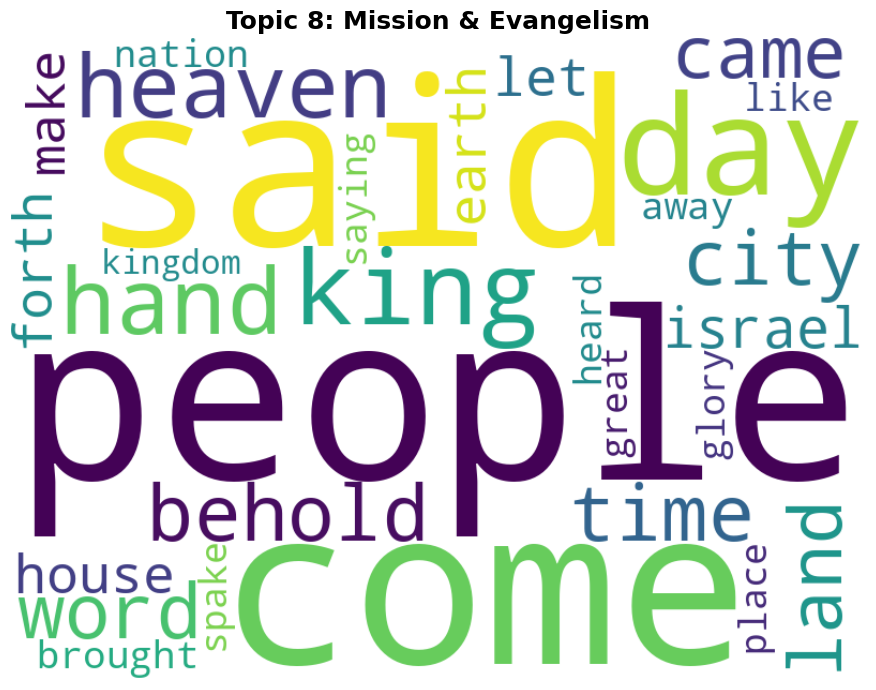

In [30]:
# ==========================================
# 📊 Generate Individual Word Clouds with Titles for Each Topic
# ==========================================

import joblib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load trained LDA model and vectorizer
model_data = joblib.load("lda_holiness_model.joblib")
lda_model = model_data['model']
vectorizer = model_data['vectorizer']
feature_names = vectorizer.get_feature_names_out()

# --- Define topic titles ---
topic_titles = [
    "End Times & Judgment",
    "Prophecy and Exile",
    "Apostolic Teaching",
    "Salvation & Grace",
    "Historical Narrative",
    "Kingdom & Rule of God",
    "Purity & Ritual Holiness",
    "Mission & Evangelism"
]

# --- Create one word cloud per topic ---
for i, topic in enumerate(lda_model.components_):
    # Create frequency dictionary for the topic
    freq = {feature_names[j]: topic[j] for j in topic.argsort()[:-30 - 1:-1]}

    # Generate the word cloud
    wc = WordCloud(
        background_color='white',
        width=800,
        height=600,
        colormap='viridis'
    ).generate_from_frequencies(freq)

    # Plot each topic in its own figure
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i+1}: {topic_titles[i] if i < len(topic_titles) else 'Unnamed Topic'}",
              fontsize=18, weight='bold')
    plt.tight_layout()

    # Save each word cloud separately
    filename = f"Topic_{i+1}_{topic_titles[i].replace('&', 'and').replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved {filename}")
    plt.show()
